# Exponential curve fitting to determine $\tau$ characteristic time

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema

## Import data

In [7]:
os.listdir('/home/balazsp/Documents/OPU/')

['state_7_2.csv',
 'state_6_2.csv',
 'test1.csv',
 'state_8_1.csv',
 'state_6_T.csv',
 'state_8_T.csv',
 'state_8_2.csv',
 'state_7_1.csv',
 'freq_8_1.csv',
 'state_6_1.csv',
 'state_7_T.csv',
 'earth_mag_T.csv',
 'state_4_1.csv',
 'state_4_T.csv',
 'freq_6_1.csv',
 'test2.csv',
 'tau_2.csv',
 'freq_4_1.csv',
 'tau_T.csv',
 'freq_7_1.csv',
 'tau_1.csv',
 'state_4_2.csv',
 'earth_mag_1.csv']

In [8]:
def read_data_files(file):
    
    time = []
    values = []
    
    with open(file, mode='rt') as f:
        for idx, line in enumerate(f):

            # Skip 16 config lines (indexing from 0 - 15)
            if(idx < 16):
                continue

            # Dataline format:
            # "vvvv, tttt,"
            # 
            s = line.split(',')
            # The first element will contain the time label, while
            # the second element contains the quantity's value
            # s[0] == time
            # s[1] == value
            time.append(float(s[0]))
            values.append(float(s[1]))

    return np.array(time), np.array(values)

In [9]:
OPU_duir = '/home/balazsp/Documents/OPU/'
time, values = read_data_files(file=OPU_duir + 'tau_2.csv')

## Cut curve

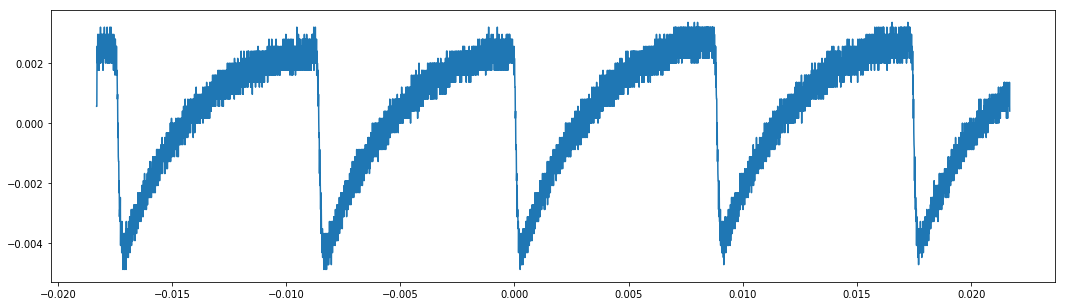

In [34]:
plt.figure(figsize=(18,5))
plt.plot(time, values)
plt.show()

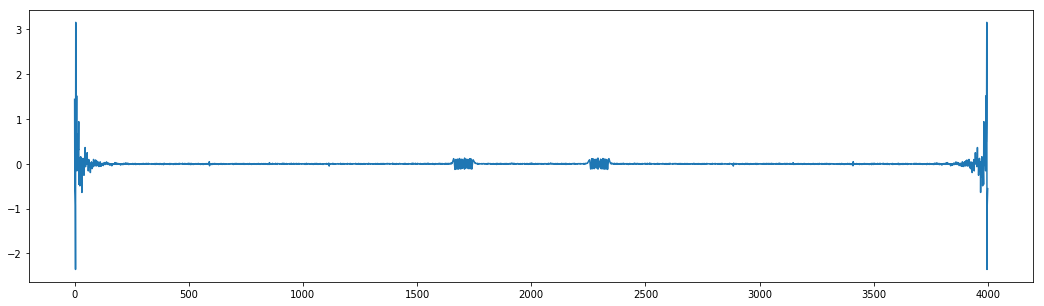

In [33]:
plt.figure(figsize=(18,5))
plt.plot(np.fft.fft(values).real)
plt.show()

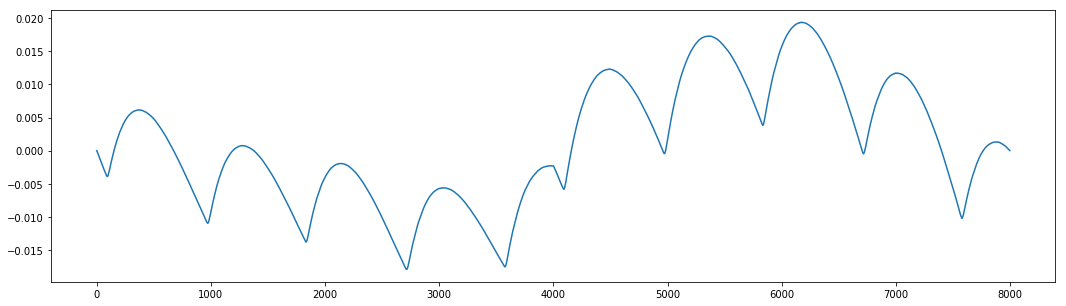

In [35]:
plt.figure(figsize=(18,5))
plt.plot(np.convolve(time, values))
plt.show()

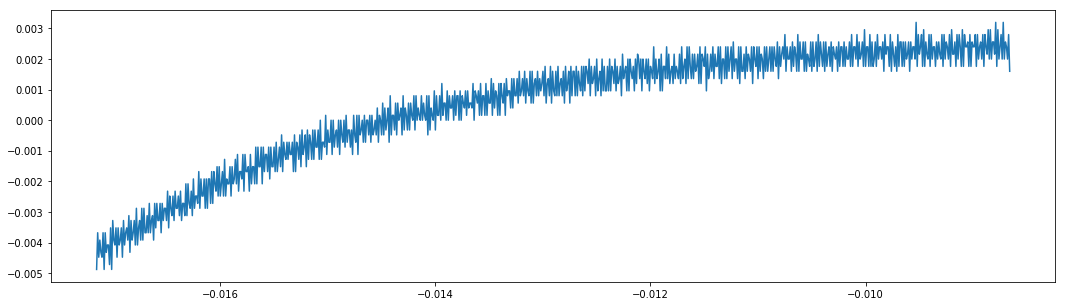

In [36]:
plt.figure(figsize=(18,5))
lower = 115
upper = 965
plt.plot(time[lower:upper], values[lower:upper])
plt.show()

In [42]:
time = time[lower:upper]
values = values[lower:upper]

## Fit exponential

In [43]:
def fit_func(t, A, B, C):
    #return A + B * np.e ** (C * t + offset)
    return A + B * np.e ** (C * t)

In [44]:
def value_prep(time, values, prep=10, offset=0):
    """
    Prepares initial values for fitting exponential on input data
    with `scipy.curve_fit()`.

    Parameters
    ----------
    time : array, shape = [n_samples]
        Array of time values. Length should be identical to the values'
        array.
    values : array, shape = [n_samples]
        Array of measured values. Length should be identical to the time
        values' array.
    prep : int, initial value ``prep = 10``
        Sets the windows size for calculating the mean of short
        intervals to determine fitting coefficients.
    offset : int, optional
        Doesn't matter now.

    Returns
    -------
    A, B, C : floats
        Initial coefficients for scipy exponential fit.
    """
    # t = inf: exp(C * t(inf) + offset) = 0
    A = values[-prep:].mean()

    # t = 0: exp(C * t(0) + offset) = 1
    B = values[:prep].mean() - A

    # t = general solution
    # y = A + B * np.e ** (C * t + offset)
    # C = ln((y - A) / B) / t
    dt = len(values) // 2
    C = np.log((values[dt:dt + prep].mean() - A) / B) / time[dt:dt+prep].mean()

    print('Characteristic time : {0} s'.format((-1/C)/1000))
    
    return A, B, C

In [47]:
p0 = value_prep(time=time, values=values, prep=10, offset=0)
popt, pcov = curve_fit(fit_func, time, values, p0=p0)
perr = np.sqrt(np.diag(pcov))

Characteristic time : -7.650416524645117e-06 s


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.